In [1]:
import sys, os
sys.path.insert(0, '../..')
# os.environ["CUDA_VISIBLE_DEVICES"]=""

In [2]:
import numpy as np
import pandas as pd
import torch
from models.weighted_node2vec import WeightedNode2Vec
from dataset import triplet_dataset, pokec_data
from utils.config import DEVICE
import gc
from tqdm import trange
from utils.link_prediction import GCNLinkPrediction
import residual2vec as rv
import warnings
import faiss
import matplotlib.pyplot as plt
from utils.score import statistical_parity
from torch_geometric.utils import negative_sampling
from utils.snakemake_utils import FileResources
import seaborn as sns
from utils import snakemake_utils
warnings.filterwarnings("ignore")
gc.enable()

/data/sg/ashutiwa/miniconda3/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using GPU: cuda:0


In [3]:
y = snakemake_utils.get_dataset("small_pokec").get_grouped_col()

Using existing file soc-pokec-profiles.txt.gz
Using existing file soc-pokec-relationships.txt.gz


In [4]:
sp_score, roc_score, gini_score, embs = {}, {}, {}, {}
DATA_ROOT = '/data/sg/ashutiwa/final_results/small_pokec/'
! ls /data/sg/ashutiwa/final_results/airport/
DIRS = ['data_one/', 'data_two/', 'data_three/', 'data_four/', 'data_five/']
DATASET = 'small_pokec'
M = ["GCN_baseline", "GCN_r2v", "GCN_baseline_crosswalk", "GCN_r2v_crosswalk", 
     "GAT_baseline","GAT_r2v", "GAT_baseline_crosswalk", "GAT_r2v_crosswalk"]

TEST_ADJ_FILE='/data/sg/ashutiwa/final_results/small_pokec/data_one/small_pokec_test_adj.npz'
k=5

data_five  data_four  data_one	data_three  data_two


# distributions of positive and negative edgeswith dot product

In [5]:
def get_roc_score(df):
    from sklearn.metrics import roc_auc_score
    y_pred = np.concatenate((df.positive_dot.values, df.negative_dot.values))
    y_true = np.concatenate((np.ones_like(df.positive_dot.values), np.zeros_like(df.negative_dot.values)))
    return roc_auc_score(y_true, y_pred)



In [6]:
def plot_dot_(df, title):
#     df = pd.DataFrame({
#         "positive_dot": np.array([np.dot(a[i], p[i]) for i in trange(a.shape[0])]),
#         "negative_dot": np.array([np.dot(a[i], n[i]) for i in trange(a.shape[0])])
#     })
    
#     fig, ax = plt.subplots(1,1)
    df.positive_dot.plot(kind='density', title=title)
    df.negative_dot.plot(kind='density', title=title)
#     ax.set_xlim(-1000, 1000)
    ax.legend(['positive_neighbors', 'negative_neighbors'])
#     fig.show()

In [7]:
def create_dot_df(A, file=TEST_ADJ_FILE):
    """
    A are node embeddings of shape # nodes \times 128
    """
    # ! ls //data/sg/ashutiwa/final_results/airport/data_one/ | grep test
    #     file = '//data/sg/ashutiwa/final_results/airport/data_one/airport_test_adj.npz'

    num_nodes = A.shape[0]
    edge_index = snakemake_utils.get_edge_index_from_sparse_path(file)
    negative_edge_index = negative_sampling(edge_index=edge_index, num_nodes=num_nodes, num_neg_samples=None, method='sparse', force_undirected=True)
    dot = pd.DataFrame({
        "positive_dot": np.array([np.dot(A[edge_index[0, i].item()], A[edge_index[1, i].item()]) for i in trange(edge_index.shape[1])]),

        "negative_dot": np.array([np.dot(A[negative_edge_index[0, i].item()], A[negative_edge_index[1, i].item()]) for i in trange(negative_edge_index.shape[1])])
    })
    return dot

In [8]:
def get_roc_score_(A, df):
    from sklearn.metrics import roc_auc_score
    from sklearn.linear_model import LogisticRegression
    X_ = np.concatenate((df.positive_dot.values, df.negative_dot.values))
    from sklearn.preprocessing import MinMaxScaler
    scaler = MinMaxScaler()
    train_df = create_dot_df(A, '../../data_one/small_pokec_adj.npz')
    X = np.concatenate((train_df.positive_dot.values, train_df.negative_dot.values))
    y = np.concatenate((np.ones_like(train_df.positive_dot.values), np.zeros_like(train_df.negative_dot.values)))
    X = scaler.fit_transform(X.reshape(-1, 1))                              
    clf = LogisticRegression().fit(X, y)
    X_ = scaler.transform(X_.reshape(-1, 1))
    
    y_pred = clf.predict_proba(X_)
    y_pred = np.argmax(y_pred, axis=1)
    
    y_true = np.concatenate((np.ones_like(df.positive_dot.values), np.zeros_like(df.negative_dot.values)))
    return roc_auc_score(y_true, y_pred)

# GCN ( baseline)

In [9]:
model = "GCN_baseline"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + '_gcn_node2vec_embs.npy')
A = embs[model]
A.shape

(406898, 128)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 17228040/17228040 [04:59<00:00, 57618.74it/s]


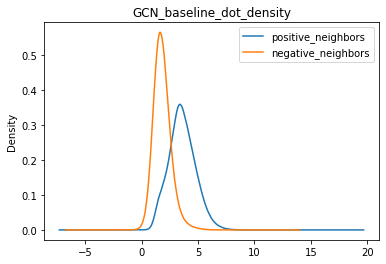

In [10]:
# plot density
dot = create_dot_df(A)
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [11]:
# # create edge_list
batch_size = 2000

edges = snakemake_utils.return_new_graph(A, k, )
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 203/203 [00:00<00:00, 250.90it/s]


((2034490, 2), 3.0520803199905816e-06, 0.8949220896933288, 0.07827624953806919)

# GCN ( baseline + crosswalk)

In [12]:
model = "GCN_baseline_crosswalk"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + '_crosswalk_gcn_node2vec_embs.npy')
A = embs[model]
A.shape


(406898, 128)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 17228040/17228040 [05:26<00:00, 52838.50it/s]


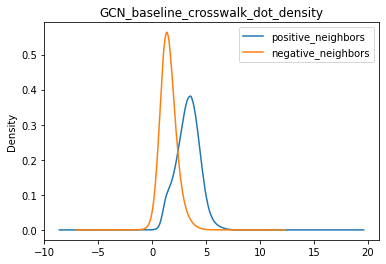

In [13]:
# plot density
dot = create_dot_df(A)
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [14]:
# # create edge_list
batch_size = 2000

edges = snakemake_utils.return_new_graph(A, k, )
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 203/203 [00:00<00:00, 251.47it/s]


((2034490, 2), 3.0807637100427536e-06, 0.9054182973155488, 0.07959358450905529)

# GCN ( r2v)

In [15]:
model = "GCN_r2v"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET  + '_gcn_r2v_node2vec_embs.npy')
A = embs[model]
A.shape

(406898, 128)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 17228040/17228040 [05:50<00:00, 49122.84it/s]


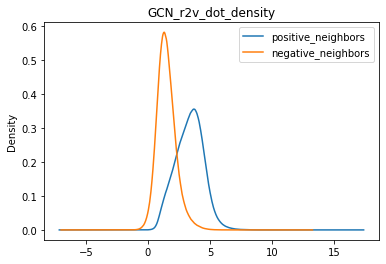

In [16]:
# plot density
dot = create_dot_df(A)
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [17]:
# # create edge_list
batch_size = 2000

edges = snakemake_utils.return_new_graph(A, k, )
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 203/203 [00:00<00:00, 246.78it/s]


((2034490, 2), 3.0645749276329043e-06, 0.9093600853906831, 0.07853747038783632)

# GCN ( r2v + crosswalk)

In [18]:
model = "GCN_r2v_crosswalk"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + '_crosswalk_gcn_r2v_node2vec_embs.npy')
A = embs[model]

A.shape

(406898, 128)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 17228040/17228040 [05:52<00:00, 48885.29it/s]


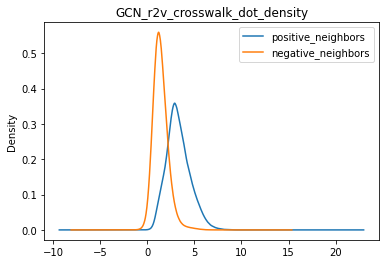

In [19]:
# plot density
dot = create_dot_df(A)
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [20]:
# # create edge_list
batch_size = 2000

edges = snakemake_utils.return_new_graph(A, k, )
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 203/203 [00:00<00:00, 244.71it/s]


((2034490, 2), 3.048789030284477e-06, 0.9041390290502841, 0.07881243400858105)

# GAT ( baseline)

In [21]:
model = "GAT_baseline"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + '_gat_node2vec_embs.npy')
A = embs[model]

A.shape

(406898, 128)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 17228040/17228040 [05:56<00:00, 48314.22it/s]


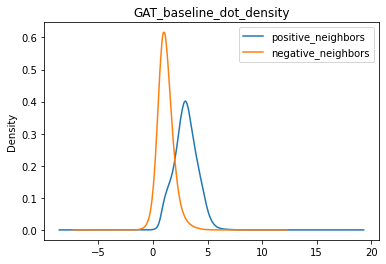

In [22]:
# plot density
dot = create_dot_df(A)
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [23]:
# # create edge_list
batch_size = 2000

edges = snakemake_utils.return_new_graph(A, k, )
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 203/203 [00:00<00:00, 257.73it/s]


((2034490, 2), 3.083414557963389e-06, 0.9182845971491262, 0.07883868468655587)

# GAT ( baseline + crosswalk)

In [24]:
model = "GAT_baseline_crosswalk"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + '_crosswalk_gat_node2vec_embs.npy')
A = embs[model]
A.shape

(406898, 128)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 17228040/17228040 [05:42<00:00, 50268.30it/s]


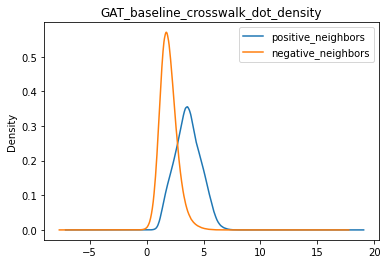

In [25]:
# plot density
dot = create_dot_df(A)
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [26]:
# # create edge_list
batch_size = 2000

edges = snakemake_utils.return_new_graph(A, k, )
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 203/203 [00:00<00:00, 213.04it/s]


((2034490, 2), 3.055995838342824e-06, 0.8868740452824279, 0.07885375840903794)

# GAT ( r2v)

In [27]:
model = "GAT_r2v"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + '_gat_r2v_node2vec_embs.npy')
A = embs[model]
A.shape

(406898, 128)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 17228040/17228040 [05:57<00:00, 48220.84it/s]


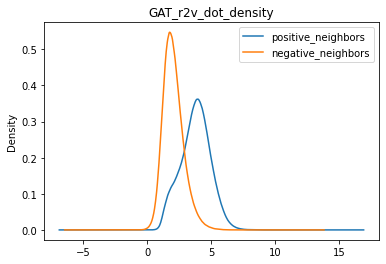

In [28]:
# plot density
dot = create_dot_df(A)
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [29]:
# # create edge_list
batch_size = 2000

edges = snakemake_utils.return_new_graph(A, k, )
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 203/203 [00:00<00:00, 232.64it/s]


((2034490, 2), 3.072225636299189e-06, 0.8826221315522338, 0.0785909792874125)

# GAT ( r2v + crosswalk)

In [30]:
model = "GAT_r2v_crosswalk"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + '_crosswalk_gat_r2v_node2vec_embs.npy')
A = embs[model]
A.shape

(406898, 128)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 17228040/17228040 [05:55<00:00, 48517.94it/s]


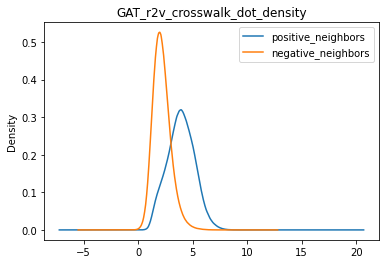

In [31]:
# plot density
dot = create_dot_df(A)
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [32]:
# # create edge_list
batch_size = 2000

edges = snakemake_utils.return_new_graph(A, k, )
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 203/203 [00:00<00:00, 224.46it/s]


((2034490, 2), 3.0798007541420103e-06, 0.8758169039699114, 0.07980480808322961)

# plot statistical parity scores

# gini sp scores

GCN_baseline 0.07827624953806919
GCN_baseline_crosswalk 0.07959358450905529
GCN_r2v 0.07853747038783632
GCN_r2v_crosswalk 0.07881243400858105
GAT_baseline 0.07883868468655587
GAT_baseline_crosswalk 0.07885375840903794
GAT_r2v 0.0785909792874125
GAT_r2v_crosswalk 0.07980480808322961


Text(0.5, 1.0, 'gini statistical parity scores')

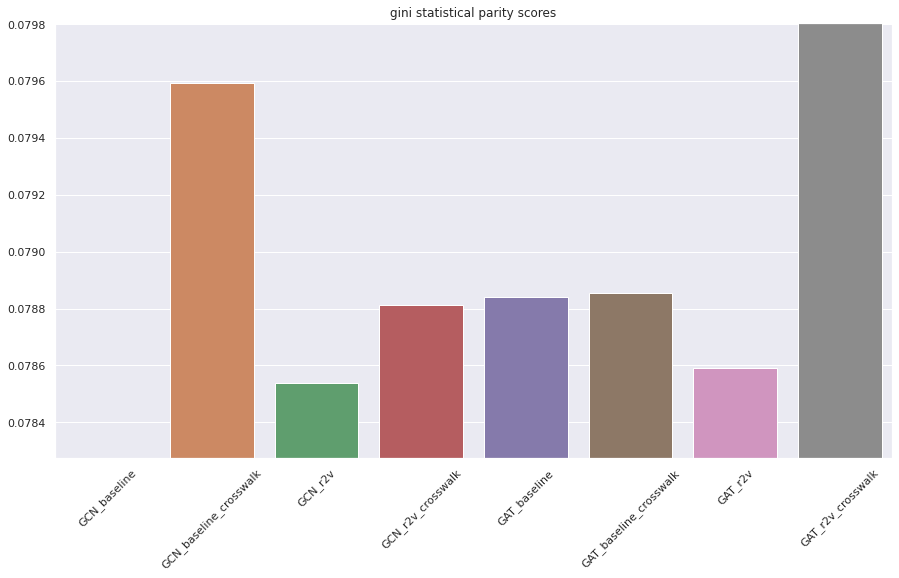

In [33]:

for i, j in gini_score.items(): print(i, j)
sns.set(rc = {'figure.figsize':(15,8)})
ax = sns.barplot(x=list(gini_score.keys()), y=list(gini_score.values()))
ax.set_ylim(min(gini_score.values()), max(gini_score.values()))
ax.set_xticklabels(ax.get_xticklabels(),rotation = 45)
ax.set_title("gini statistical parity scores")

# sp scores

GCN_baseline 3.0520803199905816e-06
GCN_baseline_crosswalk 3.0807637100427536e-06
GCN_r2v 3.0645749276329043e-06
GCN_r2v_crosswalk 3.048789030284477e-06
GAT_baseline 3.083414557963389e-06
GAT_baseline_crosswalk 3.055995838342824e-06
GAT_r2v 3.072225636299189e-06
GAT_r2v_crosswalk 3.0798007541420103e-06


Text(0.5, 1.0, 'statistical parity scores')

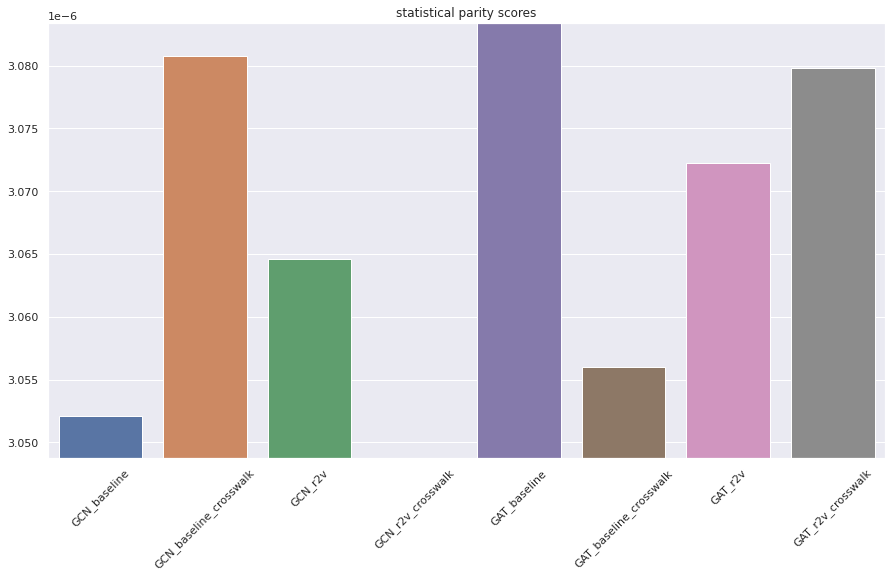

In [34]:

for i, j in sp_score.items(): print(i, j)
sns.set(rc = {'figure.figsize':(15,8)})
ax = sns.barplot(x=list(sp_score.keys()), y=list(sp_score.values()))
ax.set_ylim(min(sp_score.values()), max(sp_score.values()))
ax.set_xticklabels(ax.get_xticklabels(),rotation = 45)
ax.set_title("statistical parity scores")

# roc auc scores

GCN_baseline 0.8949220896933288
GCN_baseline_crosswalk 0.9054182973155488
GCN_r2v 0.9093600853906831
GCN_r2v_crosswalk 0.9041390290502841
GAT_baseline 0.9182845971491262
GAT_baseline_crosswalk 0.8868740452824279
GAT_r2v 0.8826221315522338
GAT_r2v_crosswalk 0.8758169039699114


Text(0.5, 1.0, 'roc scores')

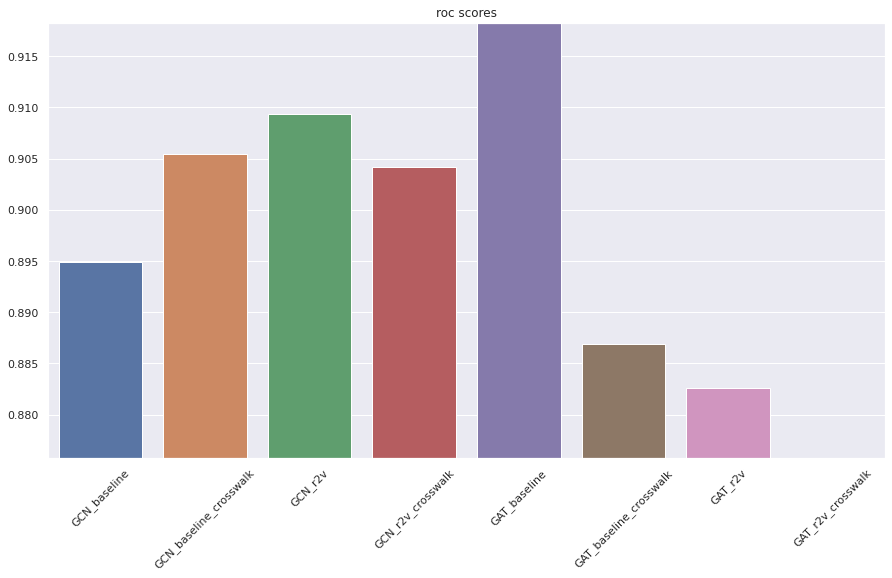

In [35]:

for i, j in roc_score.items(): print(i, j)
sns.set(rc = {'figure.figsize':(15,8)})
ax = sns.barplot(x=list(roc_score.keys()), y=list(roc_score.values()))
ax.set_ylim(min(roc_score.values()), max(roc_score.values()))
ax.set_xticklabels(ax.get_xticklabels(),rotation = 45)
ax.set_title("roc scores")

In [36]:

N = 20

sp_scores, gini_scores = np.zeros((N, len(M))), np.zeros((N, len(M)))
for k in range(N):
    for idx, m in enumerate(M):
        if k == 0: continue
        batch_size =  2000
        A = embs[m]
        edges = snakemake_utils.return_new_graph(A, k, )
        
    
        gini_scores[k, idx] = statistical_parity(edges, y, metric='gini')
        sp_scores[k, idx] = statistical_parity(edges, y, )


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 203/203 [00:00<00:00, 233.81it/s]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 203/203 [00:00<00:00, 223.56it/s]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 203/203 [00:01<00:00, 202.60it/s]


Text(0.5, 1.0, 'gini scores vs # nn')

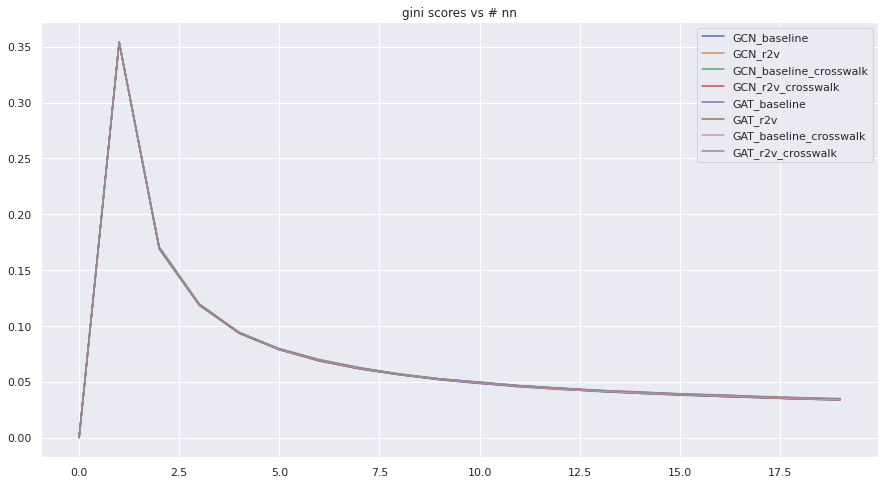

In [37]:
for i in range(len(M)):
    plt.plot(gini_scores[:, i], label=M[i])
plt.legend(loc="upper right")
plt.title("gini scores vs # nn")

Text(0.5, 1.0, 'sp scores vs # nn')

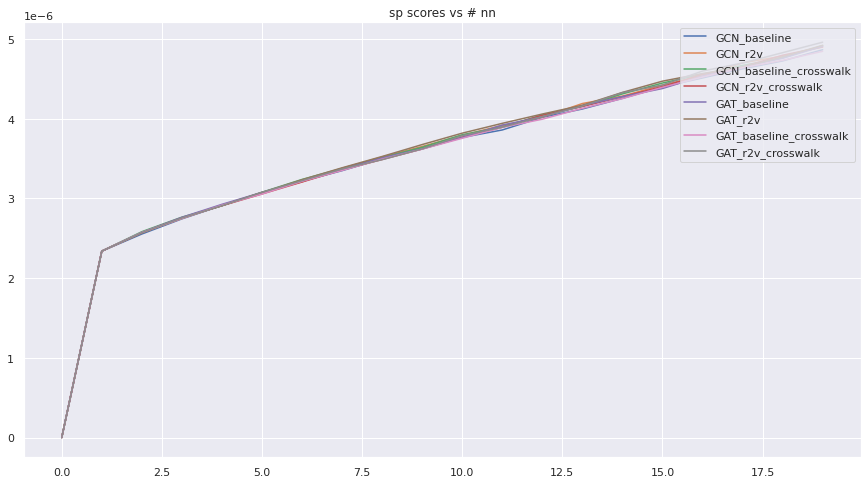

In [38]:
for i in range(len(M)):
    plt.plot(sp_scores[:, i], label=M[i])
plt.legend(loc="upper right")

plt.title("sp scores vs # nn")

# combine all different runs

In [39]:
MODEL_NAME_2_FILE = {
    "GCN_baseline": "_gcn_node2vec_embs.npy",
    "GCN_baseline_crosswalk": "_crosswalk_gcn_node2vec_embs.npy",
    "GCN_r2v": "_gcn_r2v_node2vec_embs.npy",
    "GCN_r2v_crosswalk": '_crosswalk_gcn_r2v_node2vec_embs.npy',
    "GAT_baseline": '_gat_node2vec_embs.npy',
    "GAT_baseline_crosswalk": "_crosswalk_gat_node2vec_embs.npy",
    "GAT_r2v": "_gat_r2v_node2vec_embs.npy",
    "GAT_r2v_crosswalk": "_crosswalk_gat_r2v_node2vec_embs.npy"
}
def roc_scores(model_name):
    scores = np.zeros(len(DIRS))
    for idx, d in enumerate(DIRS):
        A = np.load(DATA_ROOT + d + DATASET + MODEL_NAME_2_FILE[model_name])
        dot = create_dot_df(A)
        scores[idx] = get_roc_score(dot)
    return np.mean(scores)


def statisticalp_scores(model_name, K=5):
    scores, scores_gini = np.zeros(len(DIRS)), np.zeros(len(DIRS))
    for idx, d in enumerate(DIRS):
        A = np.load(DATA_ROOT + d + DATASET + MODEL_NAME_2_FILE[model_name])
        edges = snakemake_utils.return_new_graph(A, K)
        scores_gini[idx] = statistical_parity(edges, y, metric='gini')
        
        scores[idx] = statistical_parity(edges, y, )
    return np.mean(scores), np.mean(scores_gini)

In [ ]:

roc_score = {m: roc_scores(m) for m in MODEL_NAME_2_FILE}

for i, j in roc_score.items(): print(i, j)
sns.set(rc = {'figure.figsize':(15,8)})
ax = sns.barplot(x=list(roc_score.keys()), y=list(roc_score.values()))
ax.set_ylim(min(roc_score.values()), max(roc_score.values()))
ax.set_xticklabels(ax.get_xticklabels(),rotation = 45)
ax.set_title("roc scores")

 47%|██████████████████████████████████████████████████                                                         | 8063294/17228040 [02:33<02:24, 63412.52it/s]

In [ ]:

temp = {m: statisticalp_scores(m) for m in MODEL_NAME_2_FILE}

sp_score = {m: v[0] for m,v in temp.items()}
for i, j in sp_score.items(): print(i, j)
sns.set(rc = {'figure.figsize':(15,8)})
ax = sns.barplot(x=list(sp_score.keys()), y=list(sp_score.values()))
ax.set_ylim(min(sp_score.values()), max(sp_score.values()))
ax.set_xticklabels(ax.get_xticklabels(),rotation = 45)
ax.set_title("statistical parity scores")

In [ ]:
gini_score = {m: v[1] for m,v in temp.items()}
for i, j in gini_score.items(): print(i, j)
sns.set(rc = {'figure.figsize':(15,8)})
ax = sns.barplot(x=list(gini_score.keys()), y=list(gini_score.values()))
ax.set_ylim(min(gini_score.values()), max(gini_score.values()))
ax.set_xticklabels(ax.get_xticklabels(),rotation = 45)
ax.set_title("gini statistical parity scores")